In [1]:
# Importing Packages

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras import regularizers

from tensorflow.keras.applications import VGG16, VGG19

import talos

import pandas as pd 
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)

import seaborn as sns 
sns.set_style('darkgrid')

In [2]:
# Directory Path

train_data_dir = 'Data/train/'
test_data_dir = 'Data/test/'

# All images will be rescaled by 1./255

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Getting all the data

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_dir,
        # All images will be resized to 224x224
        target_size = (224, 224),
        batch_size = 5216,
        # Since we are planning use to binary crossentropy loss, we need binary labels
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
                  test_data_dir,
                  target_size = (224, 224),
                  batch_size = 624,
                  class_mode = 'binary')

# Creating the datasets

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# Confirming size, shape and type of datasets 

display(np.shape(train_images))
display(np.shape(train_labels))

display(type(train_images))
display(type(train_labels))

print('-------------')

display(np.shape(test_images))
display(np.shape(test_labels))

display(type(test_images))
display(type(test_labels))

(5216, 224, 224, 3)

(5216,)

numpy.ndarray

numpy.ndarray

-------------


(624, 224, 224, 3)

(624,)

numpy.ndarray

numpy.ndarray

In [4]:


pretrained = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (224, 224, 3),
                   pooling = 'avg')

2021-11-15 19:57:03.572934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Defining the CNN portion of the model

cnn = Sequential()
cnn.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in cnn.layers:
    layer.trainable = False 

In [7]:
# Adding our own dense layers

cnn.add(layers.Flatten())

cnn.add(layers.Dropout(rate = 0.2))
cnn.add(layers.Dense(192, activation = 'tanh'))

cnn.add(layers.Dropout(rate = 0.2))
cnn.add(layers.Dense(256, activation = 'tanh'))

cnn.add(layers.Dense(1, activation = 'sigmoid'))

In [8]:
# Verifying that the weights are "frozen" 

for layer in cnn.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dropout True
dense True
dropout_1 True
dense_1 True
dense_2 True


In [9]:
# Compiling the full model

cnn.compile(loss = 'binary_crossentropy', 
            optimizer = 'RMSprop', 
            metrics = ['binary_accuracy'])

In [10]:
# Reviewing the model

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               98496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [11]:
# This will stop training when the monitored metric has stopped improving
# This might be more useful when fine tuning a model

early_stopping = EarlyStopping(patience = 10,               
                               monitor = 'val_binary_accuracy',
                               restore_best_weights = True) 

# Patience = After 10 epochs with no improvement, training will be stopped
# Monitor = Validation Binary Accuracy is the quantity being monitored for the patience level
# Restoring model weights from the epoch with the best value of the monitored quantity

In [12]:
# Training the Transfer Learning CNN Model and saving its history

results_3 = cnn.fit(train_images, 
                    train_labels,
                    verbose = 2,
                    batch_size = 30, 
                    epochs = 400,
                    validation_data = (test_images, test_labels),
                    callbacks = [early_stopping])

Epoch 1/400


2021-11-15 19:57:04.046469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


174/174 - 813s - loss: 0.3163 - binary_accuracy: 0.8593 - val_loss: 0.4410 - val_binary_accuracy: 0.8397
Epoch 2/400
174/174 - 946s - loss: 0.1965 - binary_accuracy: 0.9225 - val_loss: 0.6714 - val_binary_accuracy: 0.7468
Epoch 3/400
174/174 - 933s - loss: 0.1709 - binary_accuracy: 0.9323 - val_loss: 0.3039 - val_binary_accuracy: 0.8878
Epoch 4/400
174/174 - 907s - loss: 0.1684 - binary_accuracy: 0.9340 - val_loss: 0.5352 - val_binary_accuracy: 0.7997
Epoch 5/400
174/174 - 913s - loss: 0.1622 - binary_accuracy: 0.9342 - val_loss: 0.5272 - val_binary_accuracy: 0.8013
Epoch 6/400
174/174 - 906s - loss: 0.1474 - binary_accuracy: 0.9450 - val_loss: 0.6261 - val_binary_accuracy: 0.7644
Epoch 7/400
174/174 - 908s - loss: 0.1458 - binary_accuracy: 0.9438 - val_loss: 0.4997 - val_binary_accuracy: 0.8237
Epoch 8/400
174/174 - 911s - loss: 0.1398 - binary_accuracy: 0.9465 - val_loss: 0.2804 - val_binary_accuracy: 0.8990
Epoch 9/400
174/174 - 907s - loss: 0.1420 - binary_accuracy: 0.9480 - val_lo

In [13]:
# Visualizing our Loss/Accuracy Curves, Classification Report, Confusion Matrices and Evaluating the Performance

def visualize_training_results(results, model, test_images, test_labels):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_binary_accuracy'])
    plt.plot(history['binary_accuracy'])
    plt.legend(['val_binary_accuracy', 'binary_accuracy'])
    plt.title('Binary Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
       
    y_hat_test = model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n')
    print('\n')
    print('Evaluating the Performance')
    print('\n')
    
    test_score = model.evaluate(test_images, test_labels, verbose = 0)
    print(f'Test Loss: {test_score[0]}')
    print(f'Test Accuracy: {test_score[1]}')

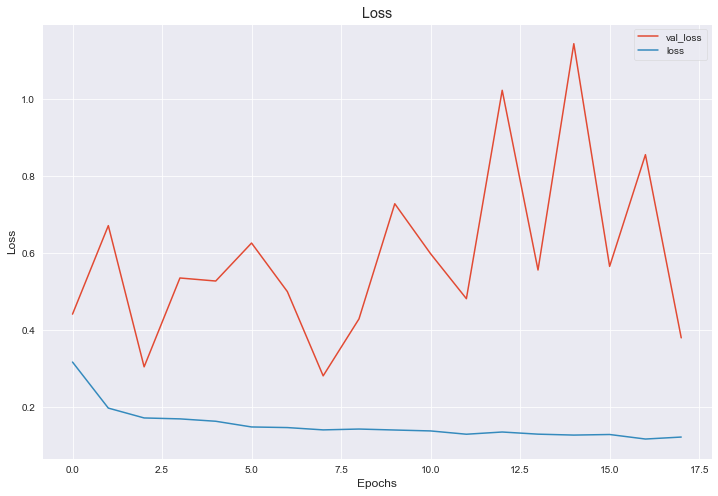

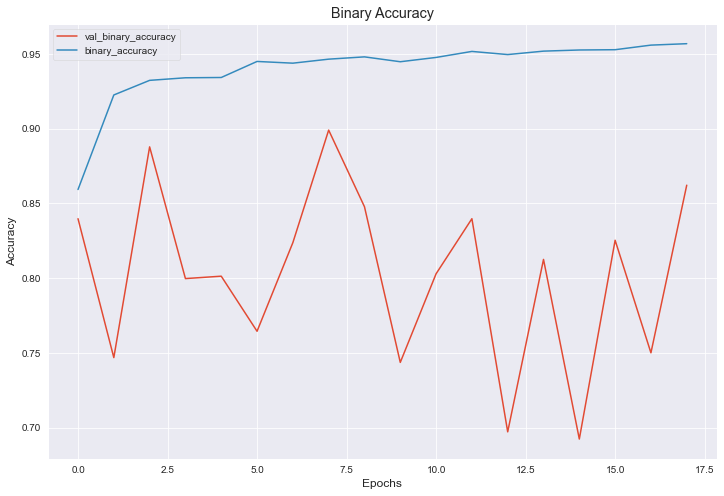

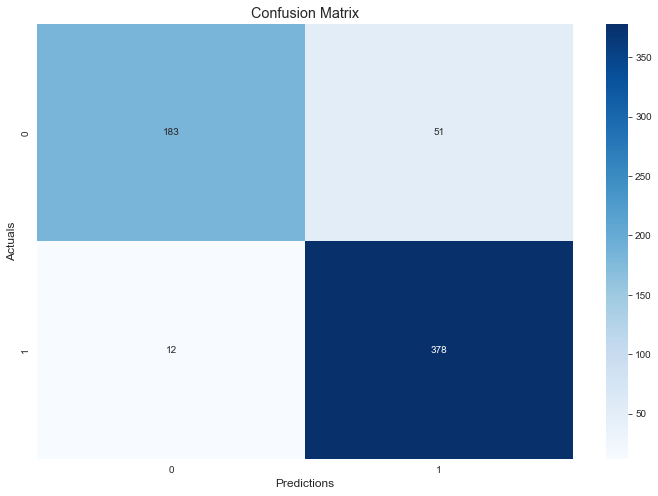

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       234
           1       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624





Evaluating the Performance


Test Loss: 0.280439168214798
Test Accuracy: 0.8990384340286255


In [14]:
visualize_training_results(results_3, cnn, test_images, test_labels)

In [ ]:
# Saving the Transfer Learning CNN Model

cnn.save('transfer_learning_cnn_model.h5')

In [16]:
# Saving the Transfer Learning CNN Model Weights

cnn.save_weights('transfer_learning_cnn_model_weights.h5')

# Transfer Learning CNN Model Summary:


* The best accuracy from the Transfer Learning CNN Model was 90%. 


* The confusion matrix shows that it is mostly predicting that there is pneumonia, when pneumonia is actually present in the X-Ray. 


* After 18 Epochs, early stopping ended the model from continually running. 


* We were able to improve the binary accuracy with use of the model and tuning methods. 
** VGG16 Pretrained Model, Early stopping, dropouts and using a different optimizer)


* The model almost reaches perfection on the training data, while the testing data fails to improve beyond Epoch 18.


* We still see the instability within the loss and accuracy curves for the valdiation data. We never see both curves smooth out and stabilize like the training data.


* My recommendation would be to use this as the model for initial insurance verification system.   